## Import Libraries and Datasets

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import sklearn.preprocessing as skpre
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import time

import VAE

In [2]:
# Load in the persons PUMS dataset for WA state
h_df = pd.read_csv("data/PUMS_2017_5YR_WA/psam_h53.csv")

## Choose PUMS and Preprocess

In [3]:
# Filter to desired variables (numeric then categorical)
pums_data = h_df[['HINCP','NP','VEH','BLD','ACCESS']].copy()

# Convert numerical variables to categorical bins
pums_data['HINCP'], hincp_bins = pd.qcut(pums_data['HINCP'], q=10, labels=False, retbins=True)
# pums_data['HINCP'], hincp_bins = pd.cut(pums_data['HINCP'], bins=20, labels=False, retbins=True)

# Remove NA values and check n before/after
print(f"Dataset n={len(pums_data)} pre-cleaning")
pums_data = pums_data.dropna()
print(f"Dataset n={len(pums_data)} post-cleaning")

Dataset n=164836 pre-cleaning
Dataset n=140586 post-cleaning


In [4]:
VAR_DIM = pums_data.shape[1]
VAR_NAMES = pums_data.columns

# Split categorical data into OHE vars, save num classes per variable
dummies_list = []
for x in range(VAR_DIM):
    dummies = pums_data.iloc[:,x]
    dummies = pd.get_dummies(dummies, prefix=f"{pums_data.columns[x]}_")
    dummies_list.append(dummies)
CAT_LENGTHS = [x.shape[1] for x in dummies_list]

In [5]:
# Final data frame after encoding OHE
model_data_df = pd.DataFrame()
for ohe_var in dummies_list:
    model_data_df = pd.concat([model_data_df, ohe_var], axis=1)
MANIFEST_DIM = model_data_df.shape[1]

# Preview data that will be fed into model
model_data_df

,HINCP__0.0,HINCP__1.0,HINCP__2.0,HINCP__3.0,HINCP__4.0,HINCP__5.0,HINCP__6.0,HINCP__7.0,HINCP__8.0,HINCP__9.0,...,BLD__4.0,BLD__5.0,BLD__6.0,BLD__7.0,BLD__8.0,BLD__9.0,BLD__10.0,ACCESS__1.0,ACCESS__2.0,ACCESS__3.0
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161771,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
161772,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
161774,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
161775,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [6]:
# Separate into train/test data
model_data = model_data_df.values
train_idx = round(len(model_data)*.03)
train_data = model_data[0:train_idx,:]
test_data = model_data[train_idx:len(model_data),:]

print(f"Training on {train_idx} samples")

Training on 4218 samples


## Set Parameters and Define Model

In [54]:
# Grid Search 1
# BATCH_SIZES = [1024, 512, 256, 128, 64, 32]
# EPOCHS = [20]
# LATENT_DIMS = [2]
# HIDDEN_DIMS = [8,16,32,64]
# KL_WEIGHTS = [0.01,0.05,0.1,0.5]
# [14.05646538734436, <tf.Tensor: shape=(), dtype=float32, numpy=1.9191134>, <tf.Tensor: shape=(), dtype=float32, numpy=3.025887>, KstestResult(statistic=0.5773528502126812, pvalue=0.0), Power_divergenceResult(statistic=122581.11806601255, pvalue=0.0), [1024, 20, 2, 32, 0.01]]
# [11.231985330581665, <tf.Tensor: shape=(), dtype=float32, numpy=40.03866>, <tf.Tensor: shape=(), dtype=float32, numpy=4.05524>, KstestResult(statistic=0.41753790846883754, pvalue=0.0), Power_divergenceResult(statistic=122300.09878929473, pvalue=0.0), [1024, 20, 2, 8, 0.01]]
# [11.231985330581665, <tf.Tensor: shape=(), dtype=float32, numpy=40.03866>, <tf.Tensor: shape=(), dtype=float32, numpy=4.05524>, KstestResult(statistic=0.41753790846883754, pvalue=0.0), Power_divergenceResult(statistic=122300.09878929473, pvalue=0.0), [1024, 20, 2, 8, 0.01]]

# Grid Search 2
# BATCH_SIZES = [4096, 2048, 1024, 512]
# EPOCHS = [20, 40]
# LATENT_DIMS = [2]
# HIDDEN_DIMS = [4, 8, 16, 32]
# KL_WEIGHTS = [.001, .005, 0.01, 0.05]
# [26.794755935668945, <tf.Tensor: shape=(), dtype=float32, numpy=2.0033364>, <tf.Tensor: shape=(), dtype=float32, numpy=2.1165783>, KstestResult(statistic=0.6072337345112601, pvalue=0.0), Power_divergenceResult(statistic=122765.4937961509, pvalue=0.0), [1024, 40, 2, 32, 0.005]]
# [7.162848949432373, <tf.Tensor: shape=(), dtype=float32, numpy=42.918358>, <tf.Tensor: shape=(), dtype=float32, numpy=5.0970073>, KstestResult(statistic=0.3970379084688376, pvalue=0.0), Power_divergenceResult(statistic=123332.1501197664, pvalue=0.0), [4096, 20, 2, 4, 0.001]]
# [7.162848949432373, <tf.Tensor: shape=(), dtype=float32, numpy=42.918358>, <tf.Tensor: shape=(), dtype=float32, numpy=5.0970073>, KstestResult(statistic=0.3970379084688376, pvalue=0.0), Power_divergenceResult(statistic=123332.1501197664, pvalue=0.0), [4096, 20, 2, 4, 0.001]]

# Grid Search 3
# BATCH_SIZES = [2048, 1024, 512]
# EPOCHS = [100]
# LATENT_DIMS = [2]
# HIDDEN_DIMS = [8, 16, 32]
# KL_WEIGHTS = [.001, .005, .01, .03, .05, .07, .1]
# NUM_WEIGHTS = [1, 5, 10, 15, 20]
# [69.22298073768616, <tf.Tensor: shape=(), dtype=float32, numpy=0.7053668>, <tf.Tensor: shape=(), dtype=float32, numpy=2.433684>, KstestResult(statistic=0.3483799112287141, pvalue=0.0), Power_divergenceResult(statistic=121453.35289829638, pvalue=0.0), [512, 100, 2, 16, 0.03, 20]]
# [39.46292066574097, <tf.Tensor: shape=(), dtype=float32, numpy=4.3707395>, <tf.Tensor: shape=(), dtype=float32, numpy=3.2804358>, KstestResult(statistic=0.6909941373963269, pvalue=0.0), Power_divergenceResult(statistic=121742.847546511, pvalue=0.0), [2048, 100, 2, 8, 0.001, 1]]
# [39.46292066574097, <tf.Tensor: shape=(), dtype=float32, numpy=4.3707395>, <tf.Tensor: shape=(), dtype=float32, numpy=3.2804358>, KstestResult(statistic=0.6909941373963269, pvalue=0.0), Power_divergenceResult(statistic=121742.847546511, pvalue=0.0), [2048, 100, 2, 8, 0.001, 1]]

# Grid Search 4
# BATCH_SIZES = [512]
# EPOCHS = [100]
# LATENT_DIMS = [3]
# HIDDEN_DIMS = [8, 16, 32]
# KL_WEIGHTS = [.05, .1, .5, 1.0]
# NUM_WEIGHTS = [.5, 1, 2, 5, 10, 15]
# [90.3771698474884, <tf.Tensor: shape=(), dtype=float32, numpy=1.9142284>, <tf.Tensor: shape=(), dtype=float32, numpy=0.91689825>, KstestResult(statistic=0.2516518330416969, pvalue=0.0), Power_divergenceResult(statistic=121336.76842914447, pvalue=0.0), [512, 100, 3, 32, 0.05, 2]]
# [67.4782133102417, <tf.Tensor: shape=(), dtype=float32, numpy=8.163122>, <tf.Tensor: shape=(), dtype=float32, numpy=1.3749605>, KstestResult(statistic=0.27553862404506846, pvalue=0.0), Power_divergenceResult(statistic=121310.24485971738, pvalue=0.0), [512, 100, 3, 8, 0.05, 0.5]]
# [67.4782133102417, <tf.Tensor: shape=(), dtype=float32, numpy=8.163122>, <tf.Tensor: shape=(), dtype=float32, numpy=1.3749605>, KstestResult(statistic=0.27553862404506846, pvalue=0.0), Power_divergenceResult(statistic=121310.24485971738, pvalue=0.0), [512, 100, 3, 8, 0.05, 0.5]]

BATCH_SIZE = 512
EPOCHS = 100
LATENT_DIM = 3
HIDDEN_DIM = 16
KL_WEIGHT = .05

# Best results so far:
# As the training size gets smaller, KL weight should decrease [.01-.1 seems good range]
# BATCH_SIZE = 512
# EPOCHS = 100
# LATENT_DIM = 3
# HIDDEN_DIM = 16
# KL_WEIGHT = .05
# NUM_WEIGHT = 2

# BATCH_SIZE = 512
# EPOCHS = 100
# LATENT_DIM = 3
# HIDDEN_DIM = 32
# KL_WEIGHT = .05
# NUM_WEIGHT = 2

# BATCH_SIZE = 512
# EPOCHS = 100
# LATENT_DIM = 3
# HIDDEN_DIM = 16
# KL_WEIGHT = .1
# NUM_WEIGHT = 2

# BATCH_SIZE = 512
# EPOCHS = 100
# LATENT_DIM = 2
# HIDDEN_DIM = 16
# KL_WEIGHT = .04
# NUM_WEIGHT = 10

# # Borysov
# BATCH_SIZE = 64
# EPOCHS = 10
# LEARN_RATE = 0.001
# RHO = 0.9
# LATENT_DIM = 5
# HIDDEN_DIM = 100
# KL_WEIGHT = 0.5

# Lower KLLW gives better reconstruction on the test data
# Too low KLLW gives nonsense in the synthesis
# Get KLLW as low as possible before synthesis suffers

## Training

In [8]:
# TODO: Write test_model function for SRMSE in grid search and elsewhere

In [9]:
# # Use grid search to train model and get results for many different hyperparameters
# grid_search_results = []
# for bs in BATCH_SIZES:
#     for e in EPOCHS:
#         for ld in LATENT_DIMS:
#             for hd in HIDDEN_DIMS:
#                 for klw in KL_WEIGHTS:
#                     for nw in NUM_WEIGHTS:
#                         start_time = time.time()
#                         LEN_HH = 0
#                         vae = VAE.VAE(MANIFEST_DIM, hd, ld, CAT_LENGTHS, CAT_IDX, LEN_HH, klw, nw)
#                         vae.compile(optimizer=keras.optimizers.Adam())
#                         history = vae.fit(train_data, epochs=e, batch_size=bs)
#                         train_time = (time.time()-start_time)
#                         loss_num, loss_cat, ks_test, chisq_test = test_model(vae, ld)
#                         results = [train_time, loss_num, loss_cat, ks_test, chisq_test, [bs,e,ld,hd,klw,nw]]
#                         grid_search_results.append(results)
# # results = [train_time, loss_num, loss_cat, ks_test, chisq_test, [bs,e,ld,hd,klw]]
# min_rec = 0
# min_ks = 0
# min_chisq = 0
# min_rec_value = 999999999
# min_ks_value = 999999999
# min_chisq_value = 999999999
# for i, result in enumerate(grid_search_results):
#     if result[1]+result[2] < min_rec_value:
#         min_rec = i
#         min_rec_value = result[1]+result[2]
#     if result[3][1] < min_ks_value:
#         min_ks = i
#         min_ks_value = result[3][1]
#     if result[4][1] < min_chisq_value:
#         min_chisq = i
#         min_chisq_value = result[4][1]
# print(grid_search_results[min_rec])
# print(grid_search_results[min_ks])
# print(grid_search_results[min_chisq])

In [72]:
val_loss = []
val_epochs = []
class validationCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0:
            val_epochs.append(epoch)
            # Use random sample of 1000 from test data to validate the model
            idx = np.random.randint(test_data.shape[0], size=1000)
            val_data = test_data[idx]
            results = vae.predict(val_data)
            loss_cat = VAE.get_reconstruction_loss(val_data, results, CAT_LENGTHS)
            val_loss.append(loss_cat)

In [73]:
# Train the model using single set of hyperparameters
LEN_HH = 0  # Number of household variables (used in CVAE)
start_time = time.time()

vae = VAE.VAE(MANIFEST_DIM, HIDDEN_DIM, LATENT_DIM, CAT_LENGTHS, LEN_HH, KL_WEIGHT)
vae.compile(optimizer=keras.optimizers.Adam())
history = vae.fit(train_data, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[validationCallback()])

train_time = (time.time()-start_time)
print(train_time)

Epoch 1/100
9/9 [==============================] - 0s 18ms/step - tot_loss: 11.1302 - rec_loss: 11.1139 - kl_loss: 0.0163
Epoch 2/100
9/9 [==============================] - 0s 2ms/step - tot_loss: 10.6655 - rec_loss: 10.6388 - kl_loss: 0.0267
Epoch 3/100
9/9 [==============================] - 0s 3ms/step - tot_loss: 10.1703 - rec_loss: 10.1250 - kl_loss: 0.0453
Epoch 4/100
9/9 [==============================] - 0s 3ms/step - tot_loss: 9.5716 - rec_loss: 9.4959 - kl_loss: 0.0757
Epoch 5/100
9/9 [==============================] - 0s 4ms/step - tot_loss: 8.9424 - rec_loss: 8.8237 - kl_loss: 0.1186
Epoch 6/100
9/9 [==============================] - 0s 3ms/step - tot_loss: 8.2969 - rec_loss: 8.1243 - kl_loss: 0.1726
Epoch 7/100
9/9 [==============================] - 0s 3ms/step - tot_loss: 7.7384 - rec_loss: 7.5173 - kl_loss: 0.2211
Epoch 8/100
9/9 [==============================] - 0s 3ms/step - tot_loss: 7.2787 - rec_loss: 7.0289 - kl_loss: 0.2498
Epoch 9/100
9/9 [========================

9/9 [==============================] - 0s 3ms/step - tot_loss: 3.6656 - rec_loss: 3.4026 - kl_loss: 0.2631
Epoch 70/100
9/9 [==============================] - 0s 3ms/step - tot_loss: 3.6505 - rec_loss: 3.3865 - kl_loss: 0.2639
Epoch 71/100
9/9 [==============================] - 0s 9ms/step - tot_loss: 3.6145 - rec_loss: 3.3495 - kl_loss: 0.2650
Epoch 72/100
9/9 [==============================] - 0s 3ms/step - tot_loss: 3.6229 - rec_loss: 3.3589 - kl_loss: 0.2640
Epoch 73/100
9/9 [==============================] - 0s 3ms/step - tot_loss: 3.5808 - rec_loss: 3.3155 - kl_loss: 0.2653
Epoch 74/100
9/9 [==============================] - 0s 2ms/step - tot_loss: 3.5897 - rec_loss: 3.3247 - kl_loss: 0.2650
Epoch 75/100
9/9 [==============================] - 0s 3ms/step - tot_loss: 3.5780 - rec_loss: 3.3120 - kl_loss: 0.2660
Epoch 76/100
9/9 [==============================] - 0s 2ms/step - tot_loss: 3.5158 - rec_loss: 3.2484 - kl_loss: 0.2674
Epoch 77/100
9/9 [==============================] - 0

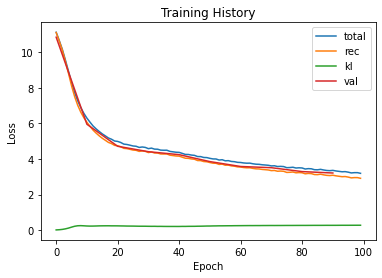

In [74]:
# Plot model loss/training progress
plt.plot(history.history['tot_loss'])
plt.plot(history.history['rec_loss'])
plt.plot(history.history['kl_loss'])
plt.plot(val_epochs, val_loss)
plt.title("Training History")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["total","rec","kl","val"], loc="upper right")
plt.show()

## Testing

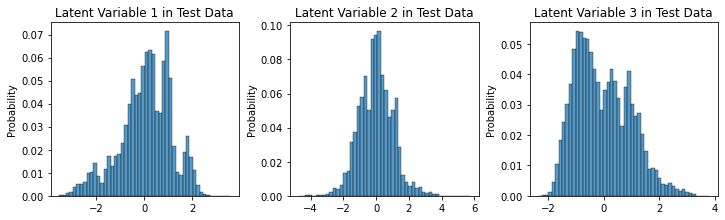

In [11]:
# Get latent vars from the encoder; feed to decoder and get sampled manifest variables
z_mean, z_logvar, z = vae.encoder.predict(test_data[:,:MANIFEST_DIM])

# Show distributions of the resulting variables
fig, axes = plt.subplots(nrows=1, ncols=LATENT_DIM, figsize=(10,3))
fig.tight_layout(w_pad=2, h_pad=10)

for i in range(LATENT_DIM):
    sns.histplot(z[:,i], ax=axes[i], bins=50, stat="probability")
    axes[i].set_title(f"Latent Variable {i+1} in Test Data")

In [76]:
# Draw predictions from test data
results = vae.predict(test_data)
loss_cat = VAE.get_reconstruction_loss(test_data, results, CAT_LENGTHS)
print(f"Categorical Variable Loss: {loss_cat}")
# print(f"SRMSE: {}")

Categorical Variable Loss: 2.978318214416504


NameError: name 'd' is not defined

In [13]:
# Transform continuous/categorical variables back to real values in the results and test data
results_df = pd.DataFrame()
test_data_df = pd.DataFrame()

# Argmax for each categorical variable the results data
for i, x in enumerate(results[0]):
    result = np.argmax(x, axis=1) + 1
    results_df[f"{i}"] = result
current = 0

# Argmax for each categorical variable the test data
for i, x in enumerate(CAT_LENGTHS):
    test_data_cat = test_data[:,current:(current + x)]
    test_data_cat = np.argmax(test_data_cat, axis=1) + 1
    test_data_df[f"{i}"] = test_data_cat
    current += x

# Add back original variables names to the results
results_df.columns = VAR_NAMES
test_data_df.columns = VAR_NAMES

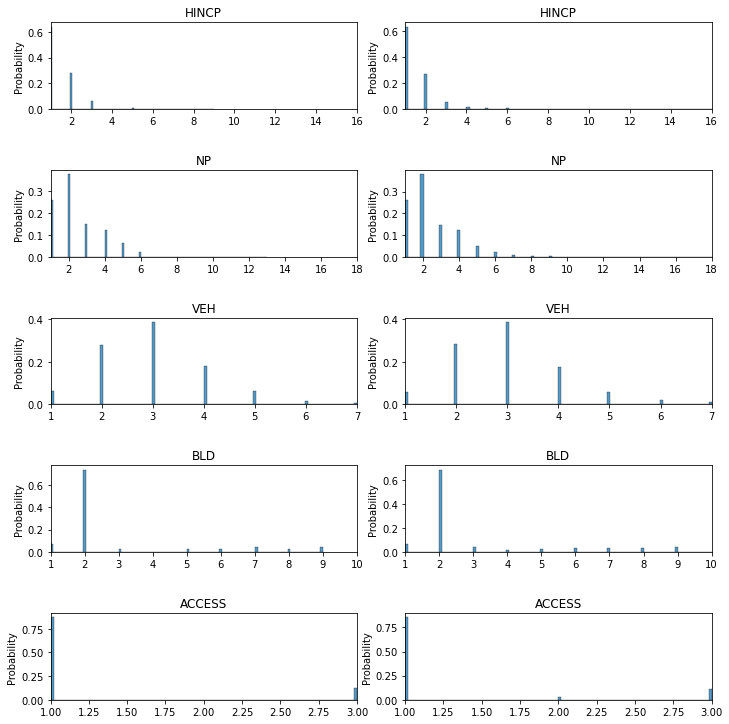

In [14]:
# Show distributions of the resulting variables
fig, axes = plt.subplots(nrows=len(VAR_NAMES), ncols=2, figsize=(10,10))
fig.tight_layout(h_pad=4)

for i, col in enumerate(VAR_NAMES):
    sns.histplot(results_df[col], ax=axes[i,0], stat='probability', bins=100).set(xlim=(min(test_data_df[col]),max(test_data_df[col])))
    axes[i,0].set_title(col)
    axes[i,0].set_xlabel(None)
    sns.histplot(test_data_df[col], ax=axes[i,1], stat='probability', bins=100).set(xlim=(min(test_data_df[col]),max(test_data_df[col])))
    axes[i,1].set_title(col)
    axes[i,1].set_xlabel(None)

## Generating Synthetic Population

In [15]:
start_time = time.time()

# How many synthetic households to generate
POP_SIZE = 100000  # Number of hh in WA

# Generate random normal sample to represent each latent variable, for each row (different hh per row)
inputs = np.random.normal(loc=0, scale=1, size=(POP_SIZE, LATENT_DIM))

# Generate households; each hh has unique latent input
results = vae.decoder.predict([inputs, inputs[:,LATENT_DIM:]])

print(f"--- {time.time() - start_time} seconds ---")

--- 1.9711391925811768 seconds ---


In [16]:
# Transform continuous/categorical variables back to real values in the results and test data
results_df = pd.DataFrame()
test_data_df = pd.DataFrame()

# Argmax for each categorical variable the results data
for i, x in enumerate(results[0]):
    result = np.argmax(x, axis=1) + 1
    results_df[f"{i}"] = result
current = 0

# Argmax for each categorical variable the test data
for i, x in enumerate(CAT_LENGTHS):
    test_data_cat = test_data[:,current:(current + x)]
    test_data_cat = np.argmax(test_data_cat, axis=1) + 1
    test_data_df[f"{i}"] = test_data_cat
    current += x

# Add back original variables names to the results
results_df.columns = VAR_NAMES
test_data_df.columns = VAR_NAMES

# In the PUMS data, VEH is indexed from 0 (sensibly). However we have just added 1 to all cat vars, so remove it
results_df['VEH'] = results_df['VEH'] - 1

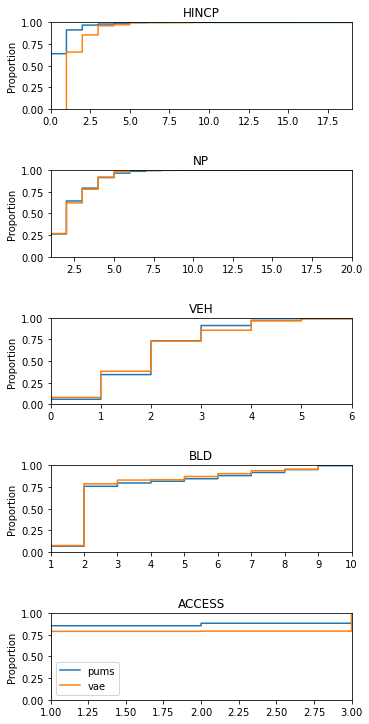

In [17]:
# Generate Distributions of All HH variables
fig, axes = plt.subplots(nrows=len(VAR_NAMES), ncols=1, figsize=(5,10))
fig.tight_layout(h_pad=4)

for i, var in enumerate(VAR_NAMES):
    sns.ecdfplot(data=pums_data, x=var, ax=axes[i]).set(xlim=(min(pums_data[var]),max(pums_data[var])))
    sns.ecdfplot(data=results_df, x=var, ax=axes[i]).set(xlim=(min(pums_data[var]),max(pums_data[var])))
    axes[i].set_title(var)
    axes[i].set_xlabel(None)
    plt.legend(labels=['pums','vae'])

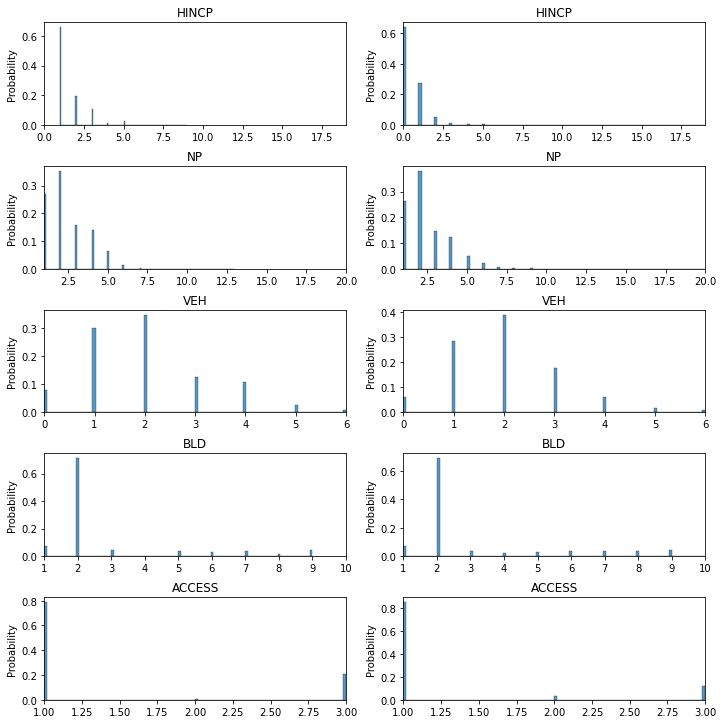

In [18]:
# Show distributions of the resulting variables
fig, axes = plt.subplots(nrows=len(VAR_NAMES), ncols=2, figsize=(10,10))
fig.tight_layout(h_pad=2, w_pad=2)

for i, col in enumerate(VAR_NAMES):
    sns.histplot(results_df[col], ax=axes[i,0], stat='probability', bins=100).set(xlim=(min(pums_data[col]),max(pums_data[col])))
    axes[i,0].set_title(col)
    axes[i,0].set_xlabel(None)
    sns.histplot(pums_data[col], ax=axes[i,1], stat='probability', bins=100).set(xlim=(min(pums_data[col]),max(pums_data[col])))
    axes[i,1].set_title(col)
    axes[i,1].set_xlabel(None)

In [19]:
# Save the synthesized households
results_df.to_csv('data/synthetic_populations/wa_households.csv', index=False)
results_df

,HINCP,NP,VEH,BLD,ACCESS
0,3,4,3,2,1
1,1,5,2,2,1
2,2,2,2,2,1
3,1,1,1,2,1
4,2,4,3,2,1
...,...,...,...,...,...
99995,1,4,2,2,2
99996,2,2,2,2,1
99997,1,1,2,2,1
99998,1,5,0,2,1
